In [ ]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import numpy as np
import tensorflow as tf
import pprint
import pandas as pd
import io
import torch
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
tf.random.set_seed(272) # DO NOT CHANGE THIS VALUE
pp = pprint.PrettyPrinter(indent=4)
img_size = 400
vgg = tf.keras.applications.VGG19(include_top=False,
                                  input_shape=(img_size, img_size, 3),
                                  weights='/content/drive/MyDrive/ML/NSTL/vgg19_weights_tf_dim_ordering_tf_kernels_notop.h5')

vgg.trainable = False
pp.pprint(vgg)

In [ ]:
# UNQ_C1
# GRADED FUNCTION: compute_content_cost

def compute_content_cost(content_output, generated_output):
    """
    Computes the content cost

    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G

    Returns:
    J_content -- scalar that you compute using equation 1 above.
    """
    a_C = content_output[-1]
    a_G = generated_output[-1]

    ### START CODE HERE

    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()


    # Reshape 'a_C' and 'a_G' (≈2 lines)
    # DO NOT reshape 'content_output' or 'generated_output'
    a_C_unrolled = tf.transpose(tf.reshape(a_C,shape=[_,-1, n_C]))
    a_G_unrolled = tf.transpose(tf.reshape(a_G,shape=[_,-1, n_C]))

    # compute the cost with tensorflow (≈1 line)
    J_content = 1/(4*n_H*n_W*n_C)*tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))

    ### END CODE HERE

    return J_content

In [ ]:
# UNQ_C2
# GRADED FUNCTION: gram_matrix

def gram_matrix(A):
    """
    Argument:
    A -- matrix of shape (n_C, n_H*n_W)

    Returns:
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    ### START CODE HERE
    #(≈1 line)
    GA = A @ tf.transpose(A)
    ### END CODE HERE

    return GA

In [ ]:
# UNQ_C3
# GRADED FUNCTION: compute_layer_style_cost

def compute_layer_style_cost(a_S, a_G):
    """
    Arguments:
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G

    Returns:
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    ### START CODE HERE

    # Retrieve dimensions from a_G (≈1 line)
    _, n_H, n_W, n_C = a_G.get_shape().as_list()

    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W) (≈2 lines)
    a_S = tf.transpose(tf.reshape(a_S,[n_H*n_W,n_C]))
    a_G = tf.transpose(tf.reshape(a_G,[n_H*n_W,n_C]))

    # Computing gram_matrices for both images S and G (≈2 lines)
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    # Computing the loss (≈1 line)
    denominator = 4*(n_H*n_W)**2*(n_C)**2
    J_style_layer = tf.reduce_sum((GS-GG)**2)/denominator

    ### END CODE HERE

    return J_style_layer

In [ ]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)]

In [ ]:
import torch
import torch.nn.functional as F

def compute_content_cost(generated_features, content_features):
    """
    Compute the content loss (MSE) between the features of the content image and the generated image.

    Parameters:
    - generated_features: Torch tensor of features from the generated image.
    - content_features: Torch tensor of features from the content image.

    Returns:
    - A torch scalar representing the content loss.
    """
    return F.mse_loss(generated_features, content_features)

def gram_matrix(features):
    """
    Compute the Gram matrix for a set of features.

    Parameters:
    - features: Torch tensor of shape (batch_size, channels, height, width).

    Returns:
    - A torch tensor representing the Gram matrix of the input features.
    """
    b, c, h, w = features.size()
    features = features.view(b, c, h * w)
    gram = torch.bmm(features, features.transpose(1, 2))
    return gram / (c * h * w)

def compute_layer_style_cost(generated_features, style_features):
    """
    Compute the style loss (MSE) between the Gram matrices of the style image and the generated image.

    Parameters:
    - generated_features: Torch tensor of features from the generated image.
    - style_features: Torch tensor of features from the style image.

    Returns:
    - A torch scalar representing the style loss.
    """
    generated_gram = gram_matrix(generated_features)
    style_gram = gram_matrix(style_features)
    return F.mse_loss(generated_gram, style_gram)

In [ ]:
### you cannot edit this cell

def compute_style_cost(style_image_output, generated_image_output, STYLE_LAYERS=STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers

    Arguments:
    style_image_output -- our tensorflow model
    generated_image_output --
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
                        - a coefficient for each of them

    Returns:
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """

    # initialize the overall style cost
    J_style = 0

    # Set a_S to be the hidden layer activation from the layer we have selected.
    # The last element of the array contains the content layer image, which must not be used.
    a_S = style_image_output[:-1]

    # Set a_G to be the output of the choosen hidden layers.
    # The last element of the list contains the content layer image which must not be used.
    a_G = generated_image_output[:-1]
    for i, weight in zip(range(len(a_S)), STYLE_LAYERS):
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])

        # Add weight * J_style_layer of this layer to overall style cost
        J_style += weight[1] * J_style_layer

    return J_style

In [ ]:
# UNQ_C4
# GRADED FUNCTION: total_cost
@tf.function()
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function

    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost

    Returns:
    J -- total cost as defined by the formula above.
    """
    ### START CODE HERE

    #(≈1 line)
    J = tf.add(alpha*J_content, beta*J_style)

    ### START CODE HERE

    return J


(1, 400, 400, 3)


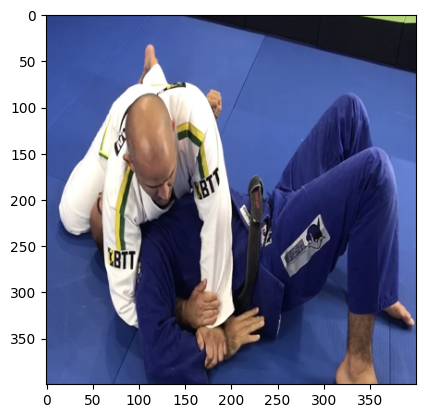

In [ ]:

# Path to your image in Google Drive
google_drive_path = '/content/drive/MyDrive/ML/NSTL/kimura.jpeg'

# img_size should be defined. Example: img_size = 224
img_size = [400, 400]  # Replace with your desired image size

with open(google_drive_path, 'rb') as f:
    img_data = f.read()

content_image = np.array(Image.open(io.BytesIO(img_data)).resize(img_size))
content_image = tf.constant(np.reshape(content_image, ((1,) + content_image.shape)))

print(content_image.shape)

# imshow from matplotlib to display the image

plt.imshow(content_image[0])





(1, 400, 400, 3)


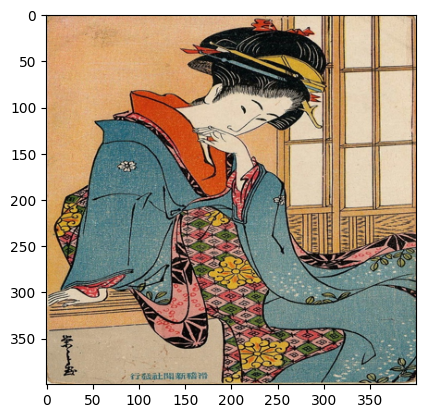

In [ ]:
google_drive_path = '/content/drive/MyDrive/ML/NSTL/classic_japanese.jpeg'

with open(google_drive_path, 'rb') as f:
    img_data = f.read()
img_size = 400

style_image =  np.array(Image.open(io.BytesIO(img_data)).resize((img_size, img_size)))
style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))

print(style_image.shape)
imshow(style_image[0])
plt.show()


(1, 400, 400, 3)


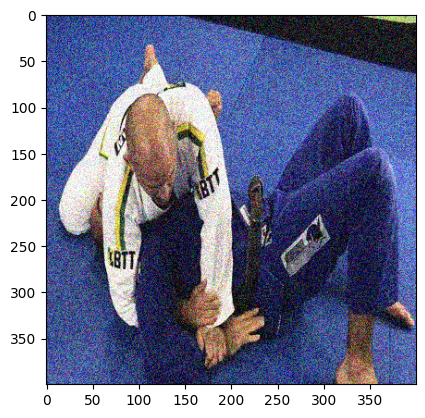

In [ ]:
generated_image = tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)

print(generated_image.shape)
imshow(generated_image.numpy()[0])
plt.show()

In [ ]:
def get_layer_outputs(vgg, layer_names):
    """ Creates a vgg model that returns a list of intermediate output values."""
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]

    model = tf.keras.Model([vgg.input], outputs)
    return model

In [ ]:
content_layer = [('block5_conv4', 1)]

vgg_model_outputs = get_layer_outputs(vgg, STYLE_LAYERS + content_layer)

In [ ]:
content_target = vgg_model_outputs(content_image)  # Content encoder
style_targets = vgg_model_outputs(style_image)     # Style encoder

In [ ]:
# Assign the content image to be the input of the VGG model.
# Set a_C to be the hidden layer activation from the layer we have selected
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(content_image, tf.float32))
a_C = vgg_model_outputs(preprocessed_content)

In [ ]:
# Assign the input of the model to be the "style" image
preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
a_S = vgg_model_outputs(preprocessed_style)

In [ ]:
def clip_0_1(image):
    """
    Truncate all the pixels in the tensor to be between 0 and 1

    Arguments:
    image -- Tensor
    J_style -- style cost coded above

    Returns:
    Tensor
    """
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

def tensor_to_image(tensor):
    """
    Converts the given tensor into a PIL image

    Arguments:
    tensor -- Tensor

    Returns:
    Image: A PIL image
    """
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)

@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:
        # Compute a_G as the vgg_model_outputs for the current generated image
        a_G = vgg_model_outputs(generated_image)

        # Ensure a_G is a dictionary-like structure with layer names as keys
        layers_of_interest_indices = [0, 1, 2, 3, 4] # Update these indices based on the actual order
        layers_of_interest_outputs = [a_G[index] for index in layers_of_interest_indices]


        # Compute the style cost
        J_style = compute_style_cost(a_S, a_G)

        # Compute the content cost
        J_content = compute_content_cost(a_C, a_G)

        # Compute the total cost
        J = total_cost(J_content, J_style, alpha = 100, beta = 5)

    # Calculate the gradients and apply them
    grad = tape.gradient(J, generated_image)
    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(clip_0_1(generated_image))

    # Return the total cost and the layers of interest outputs
    return J, layers_of_interest_outputs


In [ ]:
### you cannot edit this cell

# You always must run the last cell before this one. You will get an error if not.

generated_image = tf.Variable(generated_image)

# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again
# Show the generated image at some epochs
# Uncomment to reset the style transfer process. You will need to compile the train_step function again
epochs = 2000
printLayer = True
for i in range(epochs):
    J, layers_of_interest_outputs = train_step(generated_image)
    if i % 250 == 0:
        print(f"Epoch {i} ")
    if i % 250 == 0:
        # Assuming you're visualizing the first filter of the layer
        if(printLayer):

            for h in range(4):
                first_layer_output = layers_of_interest_outputs[h][0]

                for i in range(16):
                    ax = plt.subplot(4,4,i+1)
                    # print("layer output for: ", h, " part:",i)
                    plt.imshow(first_layer_output[:, :, i], cmap='viridis')


        # style_image =  np.array(Image.open("images/classic_japanese.jpeg").resize((img_size, img_size)))
        # style_image = tf.constant(np.reshape(style_image, ((1,) + style_image.shape)))
        # preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(style_image, tf.float32))
        a_S = vgg_model_outputs(preprocessed_style)
        image = tensor_to_image(generated_image)
        imshow(image)
        # image.save(f"output/image_{i}.jpg")
        plt.show()

AttributeError: in user code:

    File "<ipython-input-25-32cf5fdfb3f6>", line 15, in train_step  *
        J_style = compute_style_cost(a_S, a_G)
    File "<ipython-input-14-714f1893a84d>", line 30, in compute_style_cost  *
        J_style_layer = compute_layer_style_cost(a_S[i], a_G[i])
    File "<ipython-input-47-aad3ea5e5d34>", line 43, in compute_layer_style_cost  *
        generated_gram = gram_matrix(generated_features)
    File "<ipython-input-47-aad3ea5e5d34>", line 27, in gram_matrix  *
        b, c, h, w = features.size()

    AttributeError: EagerTensor object has no attribute 'size'. 
            If you are looking for numpy-related methods, please run the following:
            tf.experimental.numpy.experimental_enable_numpy_behavior()
          
